<a href="https://colab.research.google.com/github/AlejandroCarvajal49/Reinforcement_Learning/blob/main/AnalisisEntradaML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de Entrada utilizando Machine Learning
## Usando Redes neuronales con Keras

### Propósito

Por medio de este *notebook*, se busca ilustrar una aplicación de machine learning supervisado para el análisis de entrada dentro del contexto de Simulación de Eventos Discretos. En particular, se entrenará una red neuronal MLP utilizando Keras y TensorFlow, se evaluará su desempeño y visualizará los resultados.

### Contexto

Se propone analizar una clínica donde se está tratando la diabetes en mujeres, donde las pacientes necesitan empezar su tratamiento. Sin embargo, las pacientes no saben que tienen diabetes, por lo que es necesario recolectar información relevante para decidir si una paciente debe recibir consulta para tratamiento o no. Para esto, las pacientes deben pasar por una zona de registro, luego a un laboratorio clínico y finalmente a una zona donde realizan un test de glucosa. La información recolectada se encuentra en el archivo *datos_diabetes.csv* e incluye:
*   Edad de la paciente (Age)
*   Número de embarazos (Pregnant_times)
*   Historial familiar en diabetes (DiabetesFun)
*   Índice de Masa Corporal (BMI)
*   Grosor de pliegue de tríceps (Triceps)
*   Presión Arterial Diastólica (Bpressure)
*   Concentración de Glucosa en Sangre (Glucose)
*   Concentración de Insulina en Sangre (Insulin)

### Librerías a importar

A continuación se muestran los comandos a ejecutar para poder implementar los procedimientos de este notebook:


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from numpy import loadtxt
from matplotlib import pyplot  as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model
tensorflow.__version__

'2.18.0'

### Carga y separación de datos

En primer lugar, cargamos los datos a usar en este *notebook* donde la variable de interés 'Clase' es binaria y toma el valor de 1 en caso de que el paciente tenga diabetes o de 0 en caso contrario.

In [2]:
# Cargar los datos
dataset = pd.read_csv('datos_diabetes.csv', sep=",")
dataset

,Pregnant_times,Glucose,Bpressure,Triceps,Insulin,BMI,DiabetesFun,Age,Class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


Se grafican los datos usando histogramas y gráficos de dispersión entre variables, para revisar la pertinencia de los datos.

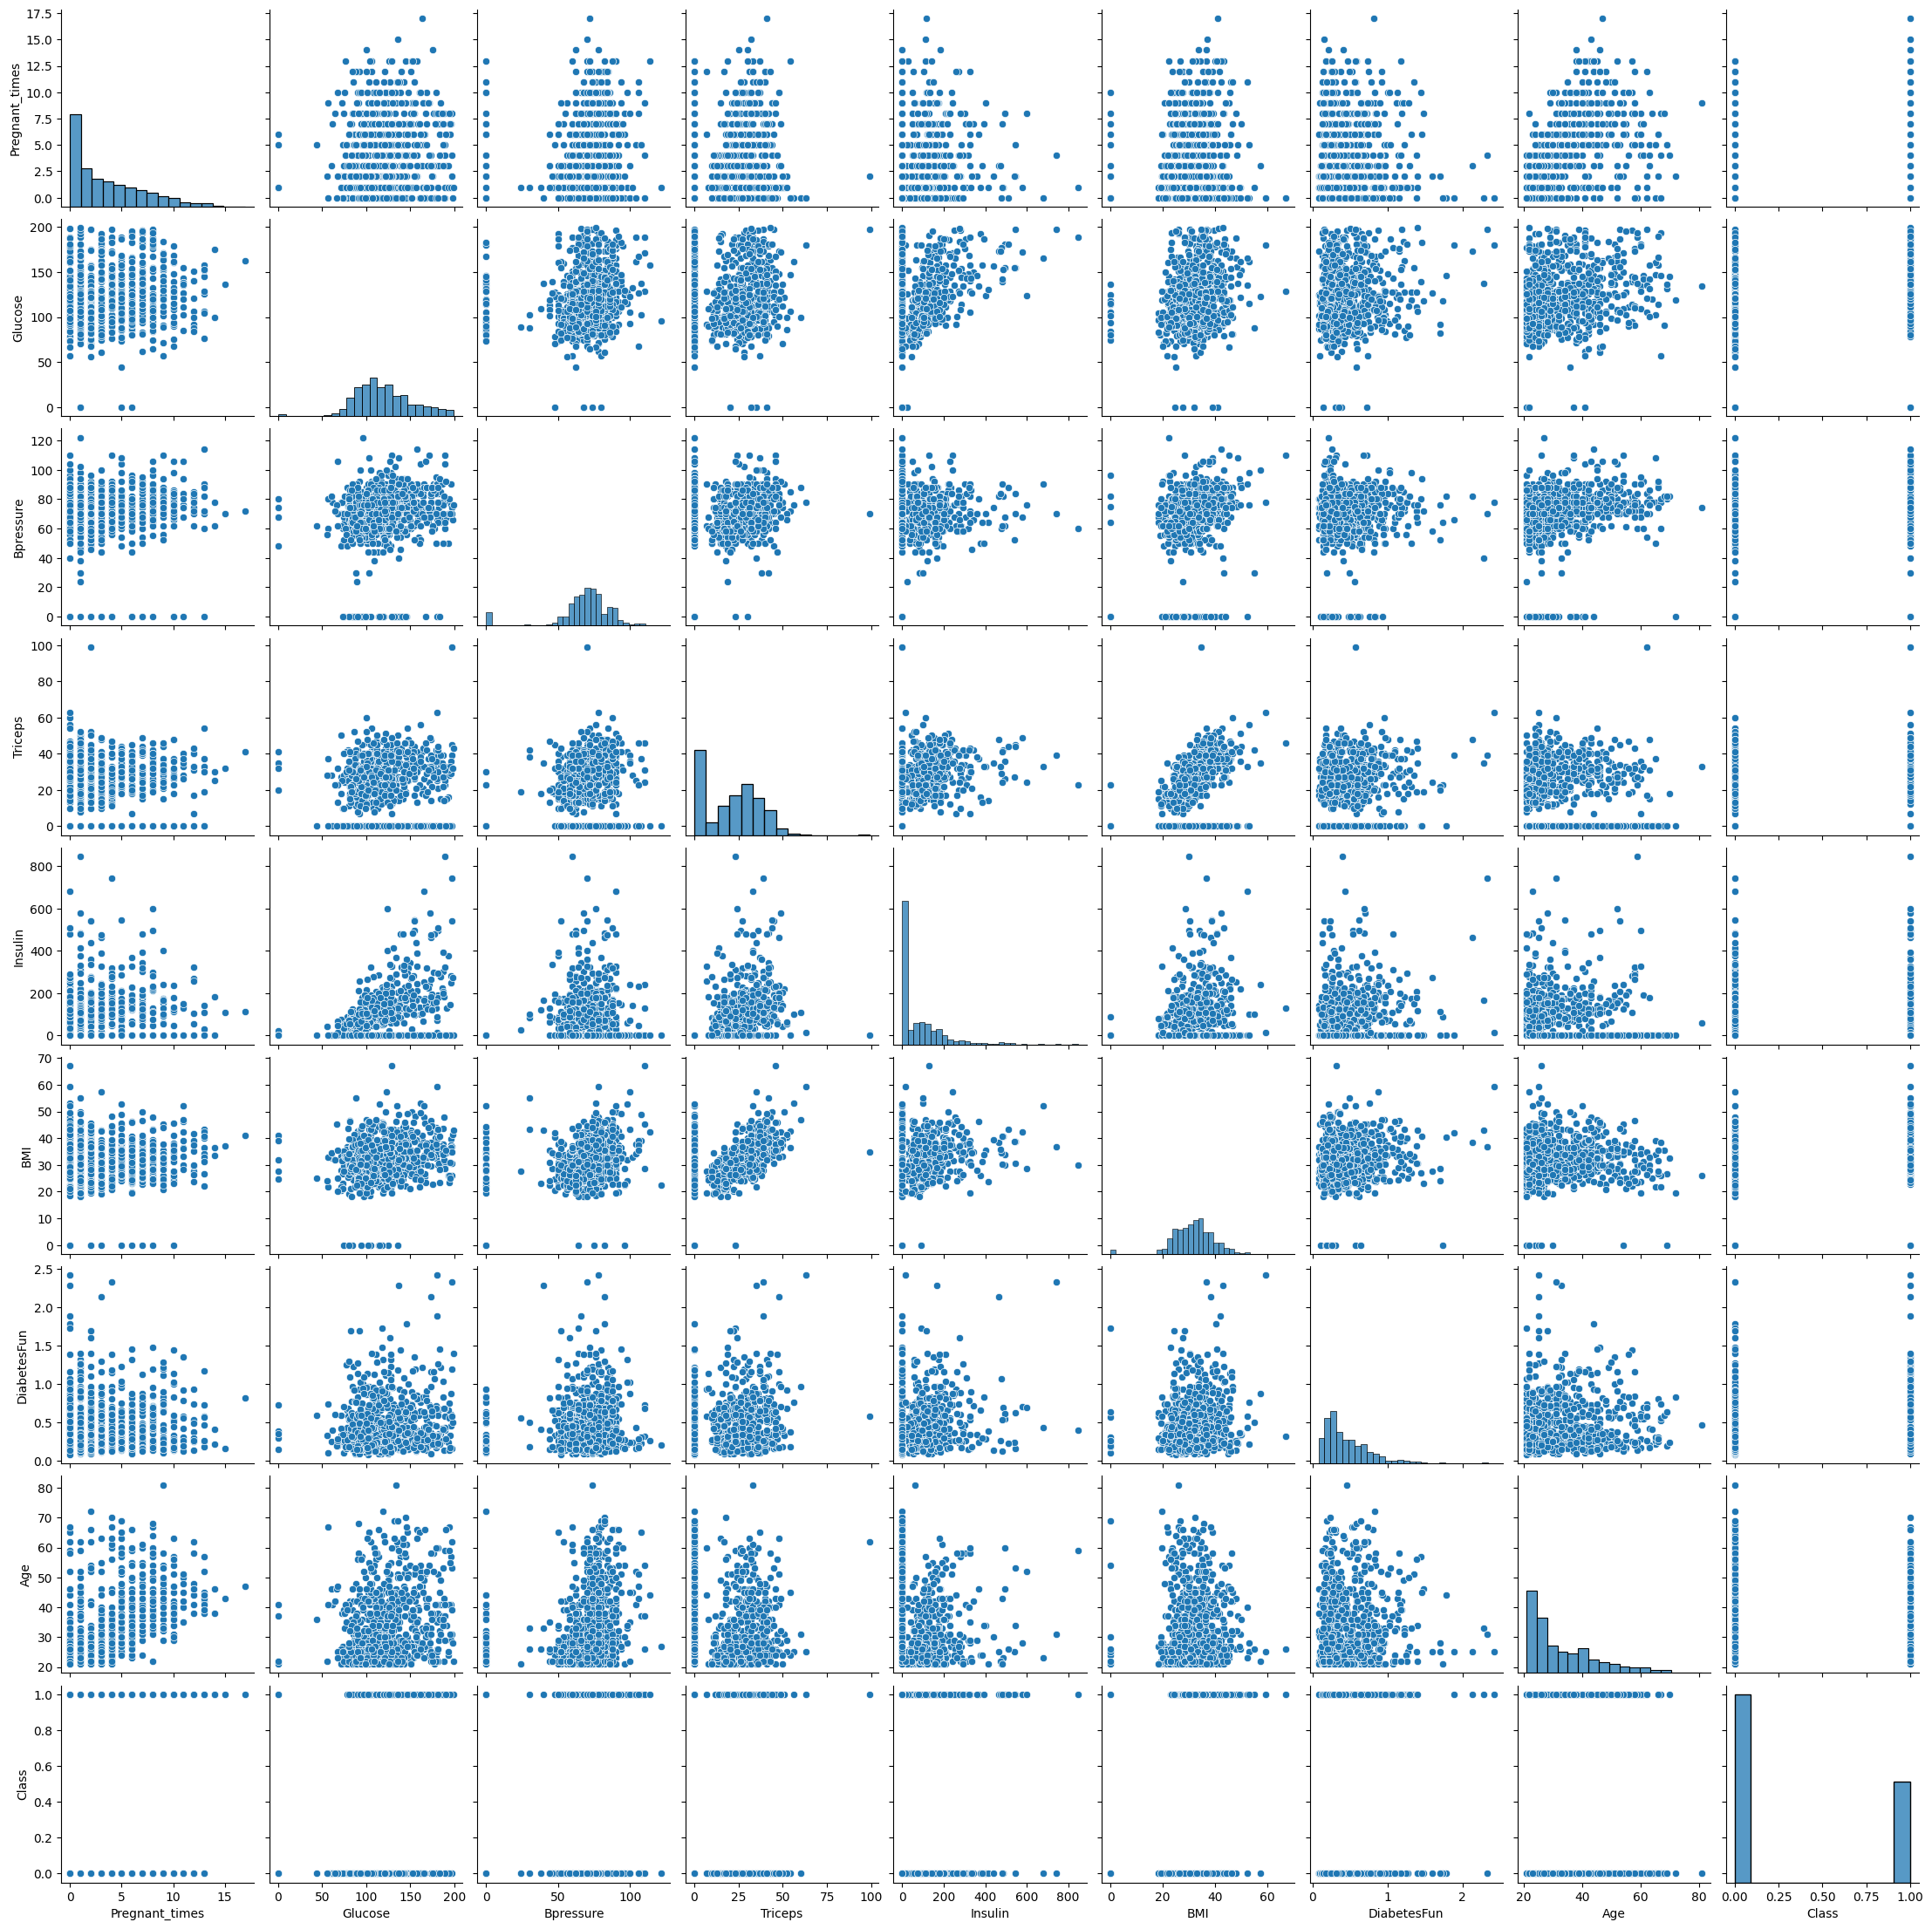

In [3]:
plt.rcParams.update(plt.rcParamsDefault)
sns.pairplot(dataset)
plt.show()

Hay una masa en cero importante en algunas variables como la concentración de insulina en sangre, que no tienen sentido médico. Es posible que estos sean datos que no se hayan registrado en algunos pacientes, por lo que se imputó el valor 0 en esos casos. Revisemos el porcentaje de valores que son 0 en estas variables:

In [ ]:
zero_features = ['Glucose','Bpressure','Triceps',"Insulin",'BMI']
total_count = dataset['Glucose'].count()
for feature in zero_features:
    zero_count = dataset[dataset[feature]==0][feature].count()
    print('{0} 0 number of cases {1}, percent is {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 number of cases 5, percent is 0.65 %
Bpressure 0 number of cases 35, percent is 4.56 %
Triceps 0 number of cases 227, percent is 29.56 %
Insulin 0 number of cases 374, percent is 48.70 %
BMI 0 number of cases 11, percent is 1.43 %


Se puede optar por ignorar las filas donde alguna de estas variables son 0; sin embargo, esto implicaría reducir bastante la base de datos. Otra opción para lidiar con esta problemática, sería imputar los outliers con alguna estrategia de llenado de datos, aunque esto puede alterar la base de datos si la imputación es significativa (como en la variable  de concentración de insulina en sangre). En este notebook, aprovecharemos la capacidad que tienen las redes neuronales para modelar no-linealidades en los datos con el objetivo de que estas aprendan a sortear esos casos, por lo que seguiremos trabajando con la base de datos original.

A continuación, se muestra la matriz de correlación entre variables:

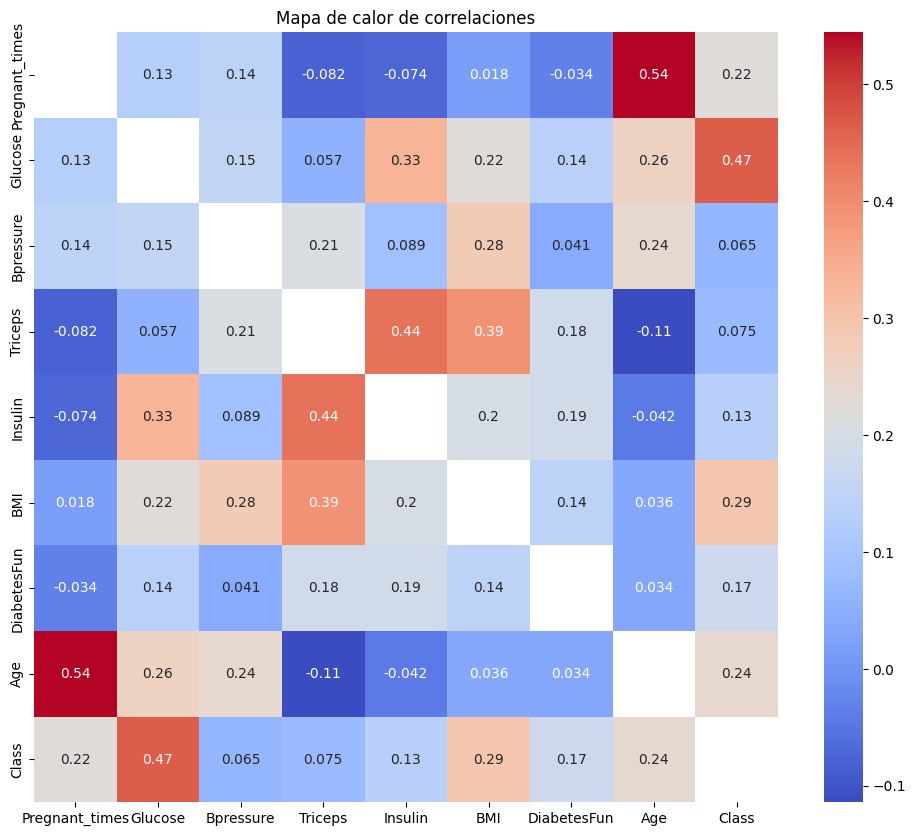

In [ ]:
plt.figure(figsize=(12, 10))
corr_matrix = dataset.corr()
mask_up = corr_matrix.abs() > 0.8
corr_matrix.abs() > 0.8
sns.heatmap(corr_matrix, annot=True, mask=mask_up,
cmap='coolwarm')
plt.title('Mapa de calor de correlaciones')
plt.show()

Ahora, partimos la base de datos en una sección de entrenamiento (train) y otra de prueba (test) de la siguiente manera: utilizaremos el 80% de los datos para calibrar el modelo y el 20% restante para evaluación.

In [4]:
# Dividir muestra en set de train y test
dataset=dataset.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(dataset[:,0:8], dataset[:,8], test_size=0.20,random_state=69)

## Modelo de red neuronal

### Creación de la red

Para solucionar este problema de clasificación, emplearemos un modelo de red neuronal secuencial de tipo _feedforward_. Para ello, creamos el objeto y procedemos a añadir cada una de las capas, especificando el número de neuronas y la función de activación en cada caso.

In [5]:
model = Sequential()
model.add(keras.Input(shape=(8,)))
model.add(Dense(8, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

### Visualización
Podemos visualizar nuestra red con ayuda de la función `graph_view()`:

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 10.7 MB/s eta 0:00:00


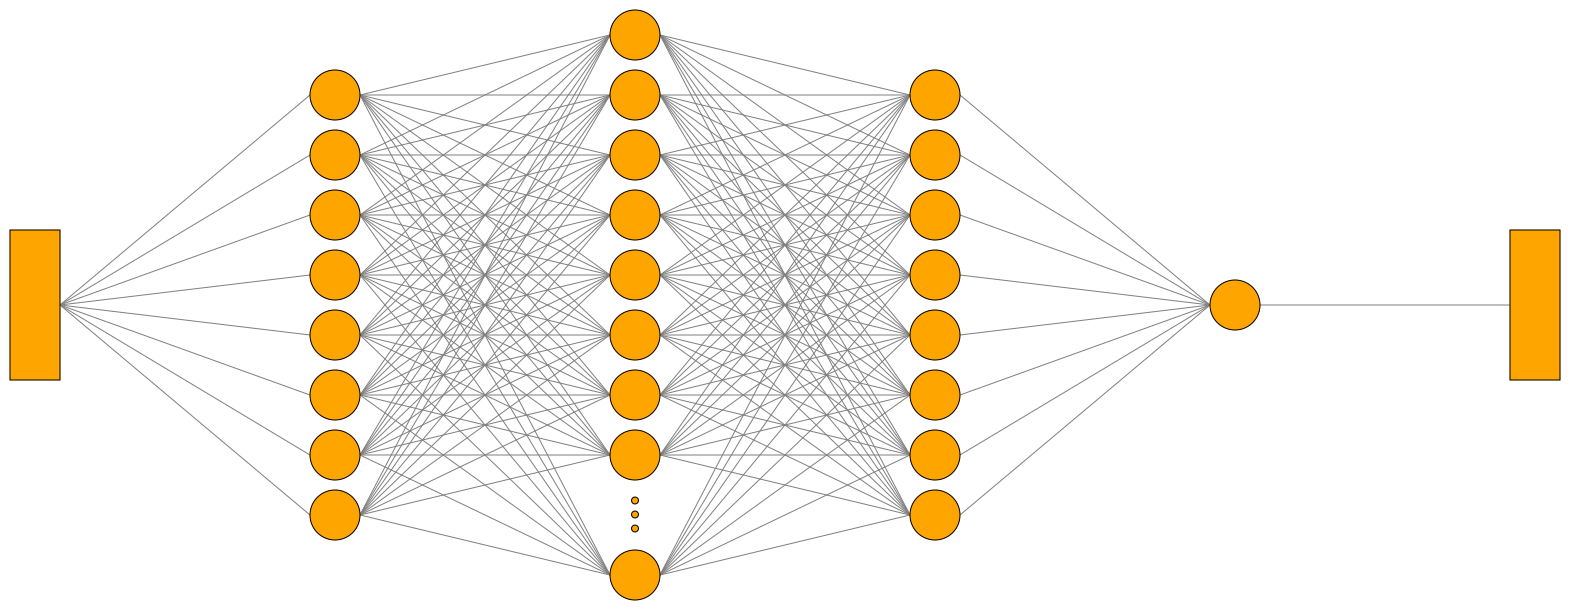

In [6]:
!pip install visualkeras
import visualkeras
visualkeras.graph_view(model)

### Compilación del modelo

Con la función [_compile( )_](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential), configuramos nuestra red para entrenarla. Definimos entonces la [función de pérdida](https://www.tensorflow.org/api_docs/python/tf/keras/losses), el [optimizador](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) y las [métricas](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) a evaluar del modelo durante el entrenamiento y prueba. Para este caso, se seleccionó la función de entropía cruzada, el optimizador Adam y el _Accuracy_ como métrica.

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Entrenamiento del modelo
Entrenamos nuestra red neuronal con los datos de entrenamiento. Podemos evidenciar el valor de la función de pérdida y el accuracy del modelo para cada epoch. ***Este entrenamiento toma entre 3 y 5 minutos en ejecutarse:***

In [8]:
history=model.fit(X_train, y_train, epochs=1500, batch_size=32, verbose=2)

Epoch 1/1500
20/20 - 2s - 102ms/step - accuracy: 0.6319 - loss: 0.6929
Epoch 2/1500
20/20 - 0s - 12ms/step - accuracy: 0.6417 - loss: 0.6419
Epoch 3/1500
20/20 - 0s - 7ms/step - accuracy: 0.6564 - loss: 0.6270
Epoch 4/1500
20/20 - 0s - 14ms/step - accuracy: 0.6384 - loss: 0.6479
Epoch 5/1500
20/20 - 0s - 7ms/step - accuracy: 0.6450 - loss: 0.6300
Epoch 6/1500
20/20 - 0s - 7ms/step - accuracy: 0.6596 - loss: 0.6234
Epoch 7/1500
20/20 - 0s - 7ms/step - accuracy: 0.6564 - loss: 0.6191
Epoch 8/1500
20/20 - 0s - 8ms/step - accuracy: 0.6808 - loss: 0.6098
Epoch 9/1500
20/20 - 0s - 14ms/step - accuracy: 0.6596 - loss: 0.6236
Epoch 10/1500
20/20 - 0s - 14ms/step - accuracy: 0.6710 - loss: 0.6069
Epoch 11/1500
20/20 - 0s - 7ms/step - accuracy: 0.6726 - loss: 0.6099
Epoch 12/1500
20/20 - 0s - 6ms/step - accuracy: 0.6629 - loss: 0.6117
Epoch 13/1500
20/20 - 0s - 8ms/step - accuracy: 0.6906 - loss: 0.6038
Epoch 14/1500
20/20 - 0s - 12ms/step - accuracy: 0.6808 - loss: 0.5992
Epoch 15/1500
20/20 - 

La anterior información también puede ser presentada gráficamente:

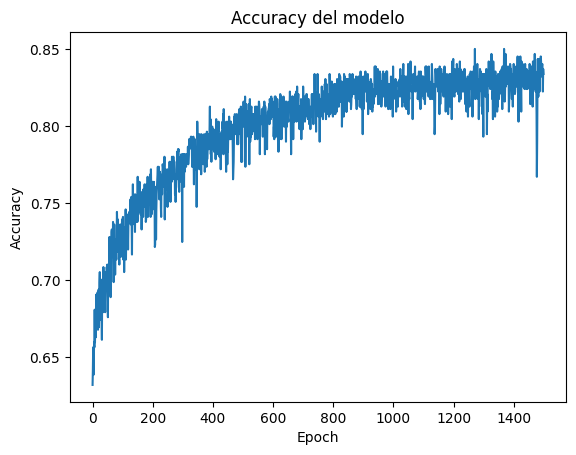

In [9]:
# Graficar accuracy del modelo
plt.plot(history.history['accuracy'])
plt.title('Accuracy del modelo')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

Calculamos el _accuracy_ del modelo para el set de train:

In [ ]:
_, accuracy = model.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7598 - loss: 0.4329
Accuracy: 78.18


### Evaluación del modelo
Podemos evaluar nuestro modelo con ayuda de la función _evaluate( )_ que retorna la función de pérdida y la métrica seleccionada (el _accuracy_ en este caso) dados los datos de prueba:

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7294 - loss: 0.6476 


Finalmente, podemos hacer predicciones sobre los datos de test utilizando el modelo y a partir de ello calcular otras métricas relevantes:

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
El accuracy del modelo es: 0.7077922077922078
La precisión del modelo es: 0.6785714285714286
La matriz de confusión es: [[90  9]
 [36 19]]
El AUC del modelo es: 0.7728191000918274


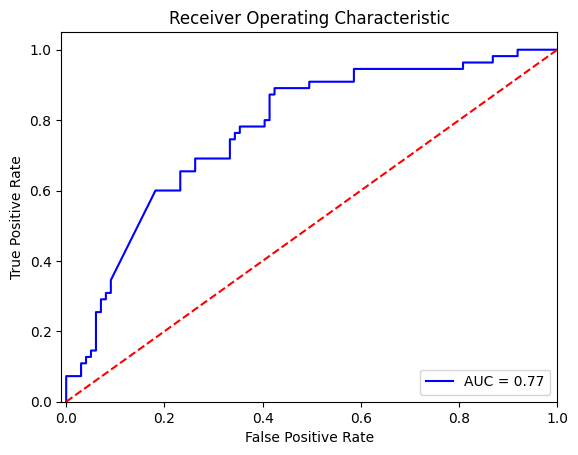

In [ ]:
# Hallar probabilidades y clasificación que predice el modelo con threshold de 0.5
predicciones = model.predict(X_test)
y_pred = [round(x[0]) for x in predicciones]
# Imprimir métricas de desempeño
print("El accuracy del modelo es: "+str(accuracy_score(y_true=y_test, y_pred=y_pred)))
print("La precisión del modelo es: "+str(precision_score(y_true=y_test, y_pred=y_pred)))
print("La matriz de confusión es: "+str(confusion_matrix(y_true=y_test, y_pred=y_pred)))
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicciones, pos_label=1)
AUCRegLog=metrics.auc(fpr, tpr)
print("El AUC del modelo es: "+str(AUCRegLog))
# Graficar curva ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUCRegLog)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

El anterior fue un modelo básico de redes neuronales que aún puede mejorarse, pero tiene un desempeño aceptable para su simpleza. Finalmente, se puede predecir cualquier combinación de valores con el modelo entrenado ingresando los valores en el orden de las columnas del dataset original.

In [ ]:
model.predict(np.array([[2,88,58,26,16,28.4,0.766,22]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


array([[0.00960851]], dtype=float32)